# gridworld
This is a simple gridworld implementation built in [openai gym](https://gym.openai.com/). The agent (☺) can move left, right, up, and down in user-defined mazes. A `nonterminal_reward` (-1 by default) is emited every step until one of the `terminal_states` is reached, each of which is associated with a user-defined reward. Actions that would move the agent into a wall do not affect the state, but still cause `nonterminal_reward` emission.

Mazes can be created from scratch or loaded from`rickgrid.mazes`. To create from scratch:

In [1]:
import gym
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import numpy as np
from rickgrid.mazes import mazes
from rickgrid import Agents

%load_ext autoreload
%autoreload 2
np.random.seed(0)

In [2]:

# make a simple maze
env = gym.make(
    'RickGrid-v0',
    walls = np.array([[0,1,0,0,0],           # logical matrix defines wall locations
                      [0,1,1,1,0],
                      [0,0,0,0,0],
                      [1,1,1,1,0],
                      [0,0,0,0,0]], dtype='bool'),
    terminal_states = [[4,0,1], [0,2,10]],   # each terminal state has [row, col, reward]
    start_coords = [0,0],                    # where the agent starts
    nonterminal_reward=-1)                   # -1 reward per non-terminal step

The environment behaves like other environments in openai gym. We can take actions visualize the result as follows:

In [3]:
env.render(); # show maze
env.step(3);  # step down
env.render(); # show maze again


██████████████
██☺ ██10    ██
██  ██████  ██
██          ██
██████████  ██
██ 1        ██
██████████████

██████████████
██  ██10    ██
██☺ ██████  ██
██          ██
██████████  ██
██ 1        ██
██████████████


# model-free control

To 'solve' these mazes, I've implmented Q-Learning, Monte Carlo, [Exact Dynamic Programming](https://web.mit.edu/dimitrib/www/RL_1-SHORT-INTERNET-POSTED.pdf), and Dynamic Programming (as described by [Sutton and Barto](http://incompleteideas.net/book/the-book-2nd.html)). I will test these methods out on this simple default maze:

In [4]:
env = mazes['basic']
env.render();


██████████████
██☺   ██   1██
██    ██    ██
██    ██    ██
██    ██    ██
██          ██
██████████████


## q-learning

We can learn policies using action-value based tabular methods. In this [Q-Learning implementation](), the agent acts $\epsilon$-greedy with respect to the estimated return for each state-action pair, $\hat{q}(s,a)$. These estimates are updated online (after each step) according to

$$\hat{q}(S_t,A_t) \leftarrow \hat{q}(S_t,A_t) + \alpha [R_t + \gamma \max_{a}\hat{q}(S_{t+1},a) - \hat{q}(S_t,A_t)]$$

where $\gamma$ is a discount factor ($\gamma=1$ for the remainder of this demo) and $\alpha$ is the learning rate.

Let's train a Q agent!



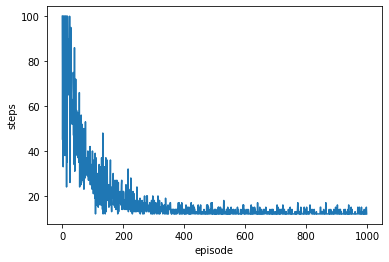

In [5]:
agent = Agents.QLearning(env)
steps = agent.train(
    iterations=1000,
    epsilon=.05,
    alpha=.05,
    gamma=1,
    online_update=True)[0]   # update q on every step

ax = plt.axes(xlabel='episode', ylabel='steps')
ax.plot(steps);

We can can check the resultant policy, which looks nice:

In [6]:
agent.show_policy()


██████████████
██▿ ▿ ██ ▹☺ ██
██▿ ▿ ██ ▹▵ ██
██▿ ▿ ██ ▹▵ ██
██ ▹▿ ██▵ ▵ ██
██ ▹ ▹ ▹▵ ▵ ██
██████████████


We can also visualize $\hat{q}(s,a)$ but taking the max across actions for every state and plotting these values as a heatmap. As expected, there are higher value estimates for locations close to the terminal state:

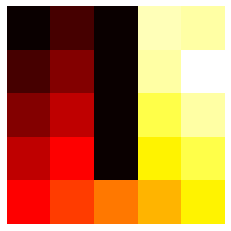

In [7]:
agent.show_q()

## monte carlo

We can also learn $\hat{q}(s,a)$ using the [Monte Carlo implementation](). Again the agent acts $\epsilon$-greedy, but the expected return for each state-action pair is estimated using an exponentially weighted emperical average. The agent is trained on-policy. Every time a state-action pair is visited, it's value estimate is updated incrementally according to:

$$\hat{q}(s,a) \leftarrow \hat{q}(s,a) + \alpha [G_t - \hat{q}(s,a)]$$

where $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} \dots \gamma^{T-t} R_T$ and $T$ is the number of time steps in the episode ($\gamma$ is again set to 0).

Let's train a Monte Carlo agent!



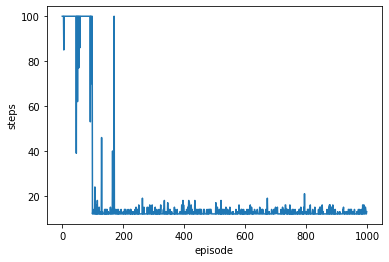

In [8]:
agent = Agents.MonteCarlo(env)
steps = agent.train(
    iterations=1000,
    epsilon=.05,
    alpha=.05,
    gamma=1)[0]

ax = plt.axes(xlabel='episode', ylabel='steps')
ax.plot(steps);

The learning curve is a little goofy. There seems to be an 'aha' moment; this is the point at which the agent accidentally discovers the terminal location. Once this happens, learning is rapid.

# model-based control

## (approximate) dynamic programming

The following approach is referred to in [Sutton and Barto as 'dynamic programming'](http://incompleteideas.net/book/the-book-2nd.html), and by [Dimitri Bertsekas as 'approximate dynamic programming'](https://web.mit.edu/dimitrib/www/RL_1-SHORT-INTERNET-POSTED.pdf). It falls within the 'generalized policy iteration' framework, wherein we iterate between approximating the value function for the current policy (evaluation) and improving the policy based on the value function (improvement).

To evaluate the action-value function for the curent policy we loop across state-action pairs and use the Bellman-like update rule

$$ \hat{q}_\pi(S_t,A_t) \leftarrow \hat{q}_\pi(S_t,A_t) + \alpha (R_{t+1} + \gamma \hat{q}_\pi(S_{t+1},A_{t+1}) - \hat{q}_\pi(S_t,A_t))$$

where $A_{t+1}$ is chosen according to the policy under evaluation. The policy is then updated by acting $\epsilon$-greedy with respect to the updated action-value function.

Note that $\hat{q}_\pi(s,a)=0 \;\; \forall \;\; (s,a)$ when the agent is initialized, which means [actions are selected randomly at first](). Even for this *random policy* a nice structure in the value function emerges after looping over the states `eval_iterations=100` times.

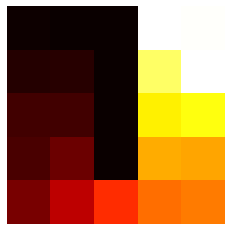

In [9]:
agent = Agents.DP_approx(env)

# evaluate current policy 1000 times and update policy once
agent.evaluate_and_update(
    eval_iterations=1000,
    alpha=.2,
    epsilon=.05)

agent.show_q()

Acting greedily with respect to this value function gives us an optimal policy after only a single round of evaluation:

In [10]:
agent.show_policy()  # the policy is now greedy w.r.t the updated q-function


██████████████
██▿ ▿ ██ ▹☺ ██
██▿ ▿ ██▵ ▵ ██
██▿ ▿ ██▵ ▵ ██
██▿ ▿ ██▵ ▵ ██
██ ▹ ▹ ▹▵ ▵ ██
██████████████


A more reasonable approach is to perform evaluation updates for just a few iterations before switching to policy improvement. Learning can occur more quickly this way:

In [11]:
agent = Agents.DP_approx(env)
policy_updates = 10
eval_iterations = 10  # evaluate each policy 10 times before updating it

steps = []
for i in range(policy_updates):
    
    # evaluate for eval_iterations and update policy once
    agent.evaluate_and_update(eval_iterations=eval_iterations, alpha=.2, epsilon=.05)
    
    # count steps in sample greedy rollout
    rewards = agent.rollout(epsilon=0, alpha=.05, gamma=1)[2]
    steps.append(len(rewards))

Once agin the agent has learned a nice policy:

In [12]:
agent.show_policy()


██████████████
██ ▹▿ ██ ▹☺ ██
██ ▹▿ ██▵ ▵ ██
██▿ ▿ ██ ▹▵ ██
██▿ ▿ ██ ▹▵ ██
██ ▹ ▹ ▹ ▹▵ ██
██████████████


But this time it only took $(10 \text{ policy updates}) * (10 \text{ evaluations per update}) = (100 \text{ evaluations})$ to get there. The plot below shows that learing has already plateaued after only 5 policy updates

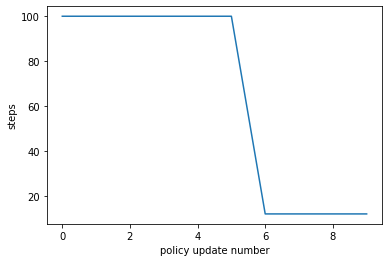

In [13]:
# plot steps per episode after each policy update
ax = plt.axes(xlabel='policy update number', ylabel='steps')
ax.plot(steps);


## (exact) dynamic programming

In [exact dynamic programming](https://web.mit.edu/dimitrib/www/RL_1-SHORT-INTERNET-POSTED.pdf) the maze is treated as a directed acyclic graph. If the reward emitted between states represents the length of the path between those states, then finding the optimal policy is finding the *longest* path through the graph.

The optimal policy is found by working backwards from the terminal states. We rely on the principle of optimality, which states that the remainder of an optimal path is also optimal. At every time, we select the optimal action for that state and time, $a_{*}(S_t, t)$,  by maximizing the sum of the immediate reward and the (optimal) value of the subsequent state:

$$ a_{*}(S_t, t) = \max_{a} \left[ r(S_t,a) + v_{*}(S_{t+1}, {t+1})  \right] $$

$v_{*}(s,t)$ is the maximum possible (undiscounted) return attainable starting from state $s$ at time $t$, and $r(s,a)$ is the reward emitted after take action $a$ in state $s$ (in a deterministic environment). In [the implementation]() I construct matrices that record the optimal values and actions for each state at each time point (assuming a fixed horizon length), starting with the last time point and moving backwards.

There is one subtlety: trajectories can be of different length (because terminal states can be reached at different times), but we would like to create matrices of size $(\text{number of states} \times \text{number of times})$ to represent *all* trajectories. The terminal state is therefore treated as a state that transitions to itself without reward until the end of the episode, which makes all trajectories have length $T$. Let's try it out.



In [14]:
agent = Agents.DP_exact(env)
agent.solve()  # this finds the optimal policy
agent.show_policy() # the policy is actually time-varying (see below); this shows t=0


██████████████
██ ▹▿ ██ ▹☺ ██
██ ▹▿ ██ ▹▵ ██
██ ▹▿ ██ ▹▵ ██
██ ▹▿ ██ ▹▵ ██
██ ▹ ▹ ▹ ▹▵ ██
██████████████


Awesome. We've actually computed optimal trajectories from *all* states at *all* times (not just the starting state and time). This means we can drop the agent at any state / time and it will still perform optimally.

## where exact dynamic programming > q-learning

What's neat about this approach is that the optimal policy is a function of state *and* time, which should allow the policy to do well even when the environment is less Markovian. Consider the following maze, where an extra *non-terminal* reward of 5 is added. An optimal policy should repeatedly consume this reward before running to catch the 99 before the maximimum duration of the episode $(T=100)$ is reached.

In [15]:
env = mazes['loops']
env.render()


██████████████████
██☺             ██
██              ██
██    99        ██
██              ██
██              ██
██           5  ██
██              ██
██████████████████


In [16]:
agent = Agents.DP_exact(env)
agent.solve() # find optimal policy

rewards = agent.rollout()[2] # get reward sequence for sample rollout

# show reward sequence
print('reward sequence:')
print(rewards)

print('\ntotal reward: {}'.format(sum(rewards)))

reward sequence:
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, 5, -1, -1, -1, -1, -1, 99]

total reward: 258


All of those $-5$ rewards correspond to the agent moving back and forward to repeatedly consume that reward, before running to catch the $99$ reward at the last moment. This means the states close to $-5$ are better early on, but those close to $99$ are better near the end. Looking at the time-indexed policies bears this out:

In [17]:
env.reset()
for t in [0,95]:
    print('\n\npolicy at t={}'.format(t))
    agent.show_policy(t=t)



policy at t=0

██████████████████
██☺  ▹ ▹ ▹ ▹▿  ◃██
██ ▹ ▹ ▹ ▹ ▹▿  ◃██
██ ▹▿ 99 ▹ ▹▿  ◃██
██ ▹ ▹ ▹ ▹ ▹▿  ◃██
██ ▹ ▹ ▹ ▹ ▹▿  ◃██
██ ▹ ▹ ▹ ▹ ▹ 5 ◃██
██ ▹ ▹ ▹ ▹ ▹▵  ◃██
██████████████████


policy at t=95

██████████████████
██☺  ▹▿  ◃ ◃ ◃ ◃██
██ ▹ ▹▿  ◃ ◃ ◃ ◃██
██ ▹ ▹99 ◃ ◃ ◃ ◃██
██ ▹ ▹▵  ◃ ◃ ◃ ◃██
██ ▹ ▹▵  ◃ ◃ ◃ ◃██
██ ▹ ▹▵  ◃ ◃ 5 ◃██
██ ◃ ▹▵  ◃ ▹▵  ◃██
██████████████████


At the beginning the agent steers *around* the big reward to get to $-5$, but moves toward $99$ at the end.

Q-Learning never achieves the maximum reward of $258$. For the following Q-Learning agent I increase $\epsilon$ to make sure the $5$ is discovered. Still the agent doesn't receive the maximum possible reward because the policy draws it toward the $99$. This is to be expected. The policy is a function of state but not time, so the agent can't learn that the $5$ is better early on, and the $99$ is better later on.

In [18]:
agent = Agents.QLearning(env)
reward = agent.train(iterations=1000, epsilon=.5, online_update=True, alpha=.05, gamma=1)[1]
print('max reward: {}'.format(max(reward)))
agent.show_policy()

max reward: 96

██████████████████
██ ▹ ▹▿  ◃ ◃▵  ▹██
██ ▹ ▹▿  ◃ ◃ ◃▿ ██
██ ▹ ▹☺  ◃ ◃ ◃ ▹██
██▵ ▵ ▵ ▵ ▵ ▿  ◃██
██▵ ▵ ▵ ▿  ▹▿  ◃██
██ ◃▿  ▹ ◃ ▹ 5 ◃██
██ ◃▵ ▿ ▿  ▹▵  ▹██
██████████████████


# explore vs. exploit!

Here is a maze that has a low-value proximal terminal state of $1$, and a high value distal terminal state of $99$.

In [19]:
env = mazes['two_terminal']
env.render()


████████████████████████████████████████████
██☺     ██        ██                      ██
██  ██    ██████  ██  ██████████████████  ██
██    ██          ██            ██        ██
██  ██  ████████  ██  ████████████  ████████
██            ██               1██      99██
████████████████████████████████████████████


For instance, the vanilla Q-Learning agent described above fails to get the maximum total reward of $63$. Instead it maxes out at a totaly reward of $-16$, which corresponds to a straight path to the $1$ reward.

max reward: -16


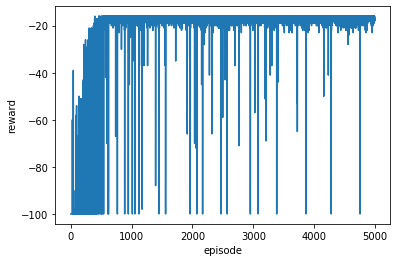

In [20]:
agent = Agents.QLearning(env)

rewards = agent.train(
    iterations=5000,
    epsilon=.05,
    alpha=.05,
    gamma=1,
    online_update=True)[1]   # update q on every step

print('max reward: {}'.format(max(rewards)))
ax = plt.axes(xlabel='episode', ylabel='reward')
ax.plot(rewards);


## fix 1: optimism in the face of uncertainty

Let's initialize $\hat{q}(s,a)$ with exremely optimistic values of $99$. This will encourage the agent to explore the unexplored, ultimately discovering the big reward.

max reward: 63


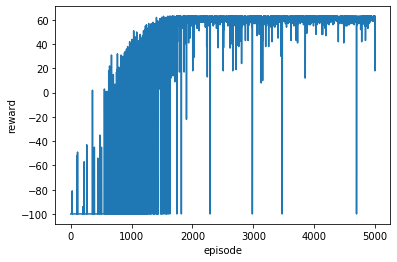

In [21]:
agent = Agents.QLearning(env, Q_init=99) # optimistic q initialization

rewards = agent.train(
    iterations=5000,
    epsilon=.05,
    alpha=.05,
    gamma=1,
    online_update=True)[1]   # update q on every step

print('max reward: {}'.format(max(rewards)))
ax = plt.axes(xlabel='episode', ylabel='reward')
ax.plot(rewards);

Success! But take a look at the policy below. Some states that aren't visited under the policy still have weird actions (like in the lower left corner). This does not affect performance unless non-greedy actions pull the agent to these strange corners of state space.

In [22]:
env.reset()
agent.show_policy()


████████████████████████████████████████████
██☺  ▹▿ ██▿  ◃▿  ◃██ ▹ ▹ ▹ ▹ ▹ ▹ ▹ ▹ ▹ ▹▿ ██
██▵ ██ ▹▿ ██████▿ ██▵ ██████████████████▿ ██
██ ▹▵ ██ ▹ ▹ ▹ ▹▿ ██▵  ◃ ▹ ▹ ▹ ▹██▿  ◃ ◃ ◃██
██ ▹██ ◃████████▿ ██▵ ████████████▿ ████████
██ ◃ ▹ ▹▵ ▵  ▹██ ▹ ▹▵ ▿  ▹▵ ▿  1██ ▹ ▹ ▹99██
████████████████████████████████████████████


## fix 2: exploring starts
Instead of starting the agent in the top left corner every time, let's randomize the start state. This guarantees the state space (but not necessarily the state-action space) is explored, and should fix the weird decisions that are made in unvisisted states shown above. We'll need to train it for a bit longer though. I also found that increasing $\epsilon$ from $.05$ to $.2$ was necessary here.

In [23]:
env.random_start = True
agent = Agents.QLearning(env) # optimistic q initialization

rewards = agent.train(
    iterations=10000,
    epsilon=.2,
    alpha=.05,
    gamma=1,
    online_update=True)[1]   # update q on every step

agent.show_policy()


████████████████████████████████████████████
██ ▹ ▹▿ ██ ▹ ▹ ▹▿ ██ ▹ ▹ ▹ ▹ ▹ ▹ ▹ ▹ ▹ ▹▿ ██
██▵ ██ ▹▿ ██████▿ ██▵ ██████████████████▿ ██
██▵  ◃██ ▹ ▹ ▹ ▹▿ ██▵  ◃ ◃ ◃ ◃ ◃██▿  ◃ ◃ ◃██
██▵ ██▿ ████████▿ ██▵ ████████████▿ ████████
██▵  ◃ ◃ ◃ ◃ ◃██ ▹ ▹▵  ◃ ◃ ▹ ▹ 1██ ▹ ▹ ▹☺ ██
████████████████████████████████████████████


The policy is still imperfect, but if we begin at the start state and set $\epsilon=0$ we we get the maximum possible reward of $63$:

In [24]:
env.random_start = False
rewards = agent.rollout(epsilon=0)[2]
print('episode reward: {}'.format(sum(rewards)))

episode reward: 63


## fix 3: exact dynamic programming
It's perhaps worth showing that dynamic programming figures this maze out:

In [25]:
agent = Agents.DP_exact(env)
agent.solve()
agent.show_policy()
rewards = agent.rollout(epsilon=0)[2]
print('episode reward: {}'.format(sum(rewards)))


████████████████████████████████████████████
██ ▹ ▹▿ ██ ▹ ▹ ▹▿ ██ ▹ ▹ ▹ ▹ ▹ ▹ ▹ ▹ ▹ ▹▿ ██
██▵ ██ ▹▿ ██████▿ ██▵ ██████████████████▿ ██
██▵  ◃██ ▹ ▹ ▹ ▹▿ ██▵  ◃ ◃ ◃ ◃ ◃██▿  ◃ ◃ ◃██
██▵ ██▿ ████████▿ ██▵ ████████████▿ ████████
██▵  ◃ ◃ ◃ ◃ ◃██ ▹ ▹▵  ◃ ◃ ◃ ◃ 1██ ▹ ▹ ▹☺ ██
████████████████████████████████████████████
episode reward: 63


## fix 4: bring the noise
todo